In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipBackend
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform

import matplotlib.pyplot as plt
import qutip

## Blockade study N.1

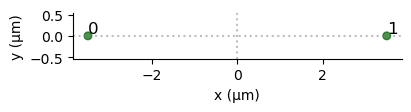

In [2]:
d = 7 #distance between qubits

coord = [(0,0), (d, 0)]
register = Register.from_coordinates(coord)
register.draw()

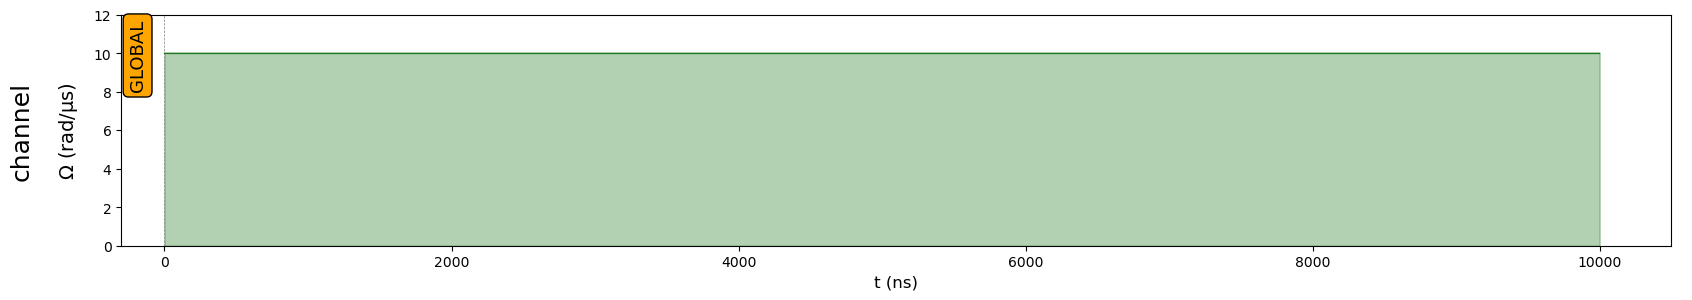

In [3]:
sequence = Sequence(register, MockDevice)

pulse = Pulse.ConstantPulse(
    duration=10000,
    amplitude=10,
    detuning=0,
    phase=0
)

sequence.declare_channel('channel', 'rydberg_global')

sequence.add(pulse, 'channel')

sequence.draw()



In [4]:
simulation = QutipBackend(sequence)

results = simulation.run()

In [5]:
# now we want to calculate the probability over time of |11>

state_1 = qutip.basis(2, 0)  # |1>
print(state_1)

state_0 = qutip.basis(2, 1) # |0>
print(state_0)

# this is the convention used in Pulser

state_11 = qutip.tensor([state_1, state_1]) # |11>
print(state_11)

observable_11 = state_11.proj()  # |11><11| projector operator onto |11>
print(observable_11)

observable_00 = qutip.tensor([state_0, state_0]).proj()
print(observable_00)

observable_superpos = (
    qutip.tensor([state_0, state_1])/np.sqrt(2) + 
    qutip.tensor([state_1, state_0])/np.sqrt(2)
).proj()


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [6]:
expectation_values = results.expect([observable_00, observable_11, observable_superpos])

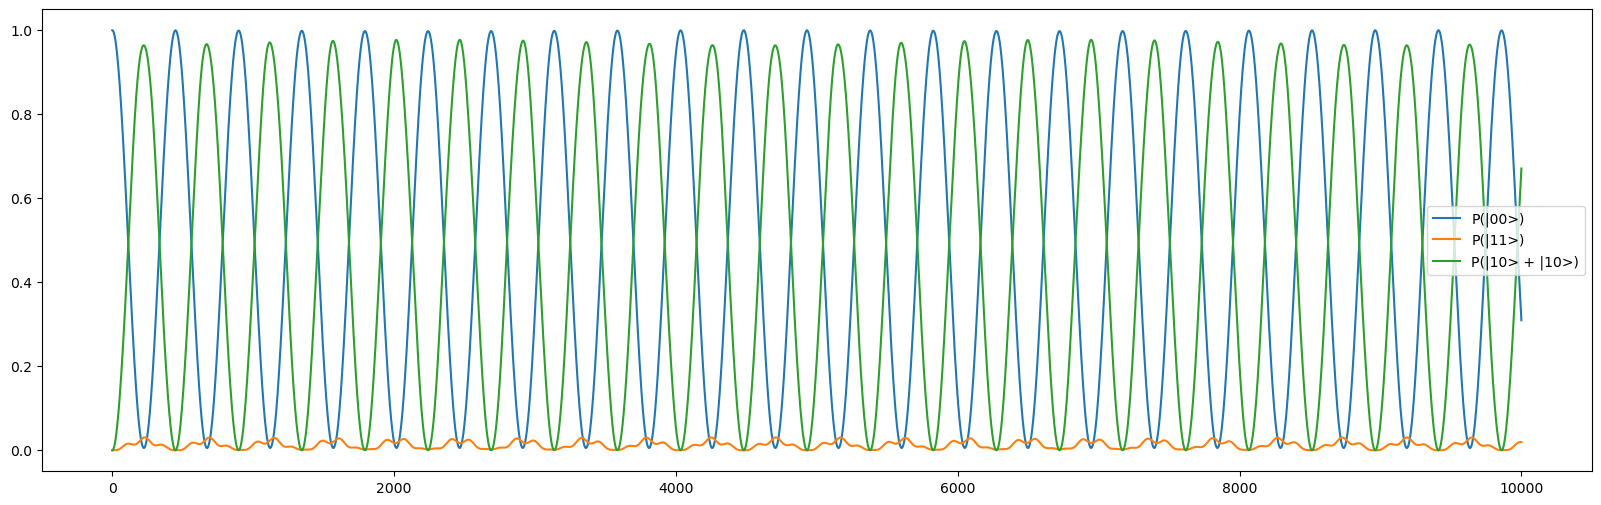

In [7]:
plt.figure(figsize=(20,6))
plt.plot(expectation_values[0], label='P(|00>)')
plt.plot(expectation_values[1], label='P(|11>)')
plt.plot(expectation_values[2], label='P(|10> + |10>)')
plt.legend()

## Blockade study N.2

In [9]:
distances = np.linspace(2, 20, 20)
amplitude = 2

blockaded = []
for d in distances:
    reg = Register.from_coordinates([(0,0), (d,0)])
    
    seq = Sequence(reg, MockDevice)
    seq.declare_channel('ch', 'rydberg_global')
    
    pulse = Pulse.ConstantPulse(
        duration=10000,
        amplitude=amplitude,
        detuning=0,
        phase=0
    )

    seq.add(pulse, 'ch')
    sim = QutipBackend(seq)
    results = sim.run()
    obs = qutip.tensor([state_1, state_1]).proj()
    exp_val = results.expect([obs])
    blockaded.append(int(np.any(exp_val[0] > .5)))

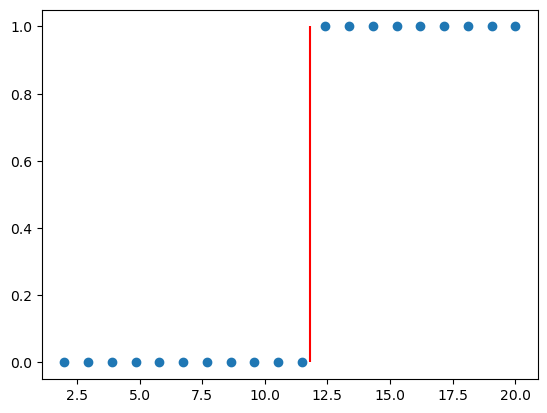

In [10]:
plt.scatter(distances, blockaded)
brad = MockDevice.rydberg_blockade_radius(amplitude)
plt.vlines(brad, 0, 1, color='red')